# Eyeglasses Segmentation Model Report
This report documents the training process of an advanced U-Net model with EfficientNetB3 backbone for eyeglasses segmentation. The sections below cover the data loading, preprocessing, model architecture, training configuration, evaluation, and visualizations.

In [1]:
# Install necessary libraries
!pip install tensorflow
# Or if using PyTorch
# !pip install torch torchvision

# Additional libraries
!pip install matplotlib numpy opencv-python


In [7]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Run the cell, capturing stdout, stderr, and IPython’s rich display() calls.
%%capture
!unzip "/content/gdrive/MyDrive/datasets/eyeglasses_dataset.zip"

43941136/43941136 [==============================] - 0s 0us/step
Epoch 1/100
50/50 [==============================] - 87s 603ms/step - loss: 0.8171 - accuracy: 0.7035 - val_loss: 0.9999 - val_accuracy: 0.9633 - lr: 1.0000e-04
Epoch 2/100
50/50 [==============================] - 16s 320ms/step - loss: 0.6404 - accuracy: 0.9277 - val_loss: 0.6707 - val_accuracy: 0.8798 - lr: 1.0000e-04
Epoch 3/100
50/50 [==============================] - 17s 327ms/step - loss: 0.6198 - accuracy: 0.9302 - val_loss: 0.7350 - val_accuracy: 0.8164 - lr: 1.0000e-04
Epoch 4/100
50/50 [==============================] - 16s 326ms/step - loss: 0.6100 - accuracy: 0.9350 - val_loss: 0.7297 - val_accuracy: 0.8322 - lr: 1.0000e-04
Epoch 5/100
50/50 [==============================] - 18s 351ms/step - loss: 0.6082 - accuracy: 0.9355 - val_loss: 0.6315 - val_accuracy: 0.9179 - lr: 1.0000e-04
Epoch 6/100
50/50 [==============================] - 17s 345ms/step - loss: 0.6004 - accuracy: 0.9422 - val_loss: 0.6913 - val_acc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 4s 4s/step


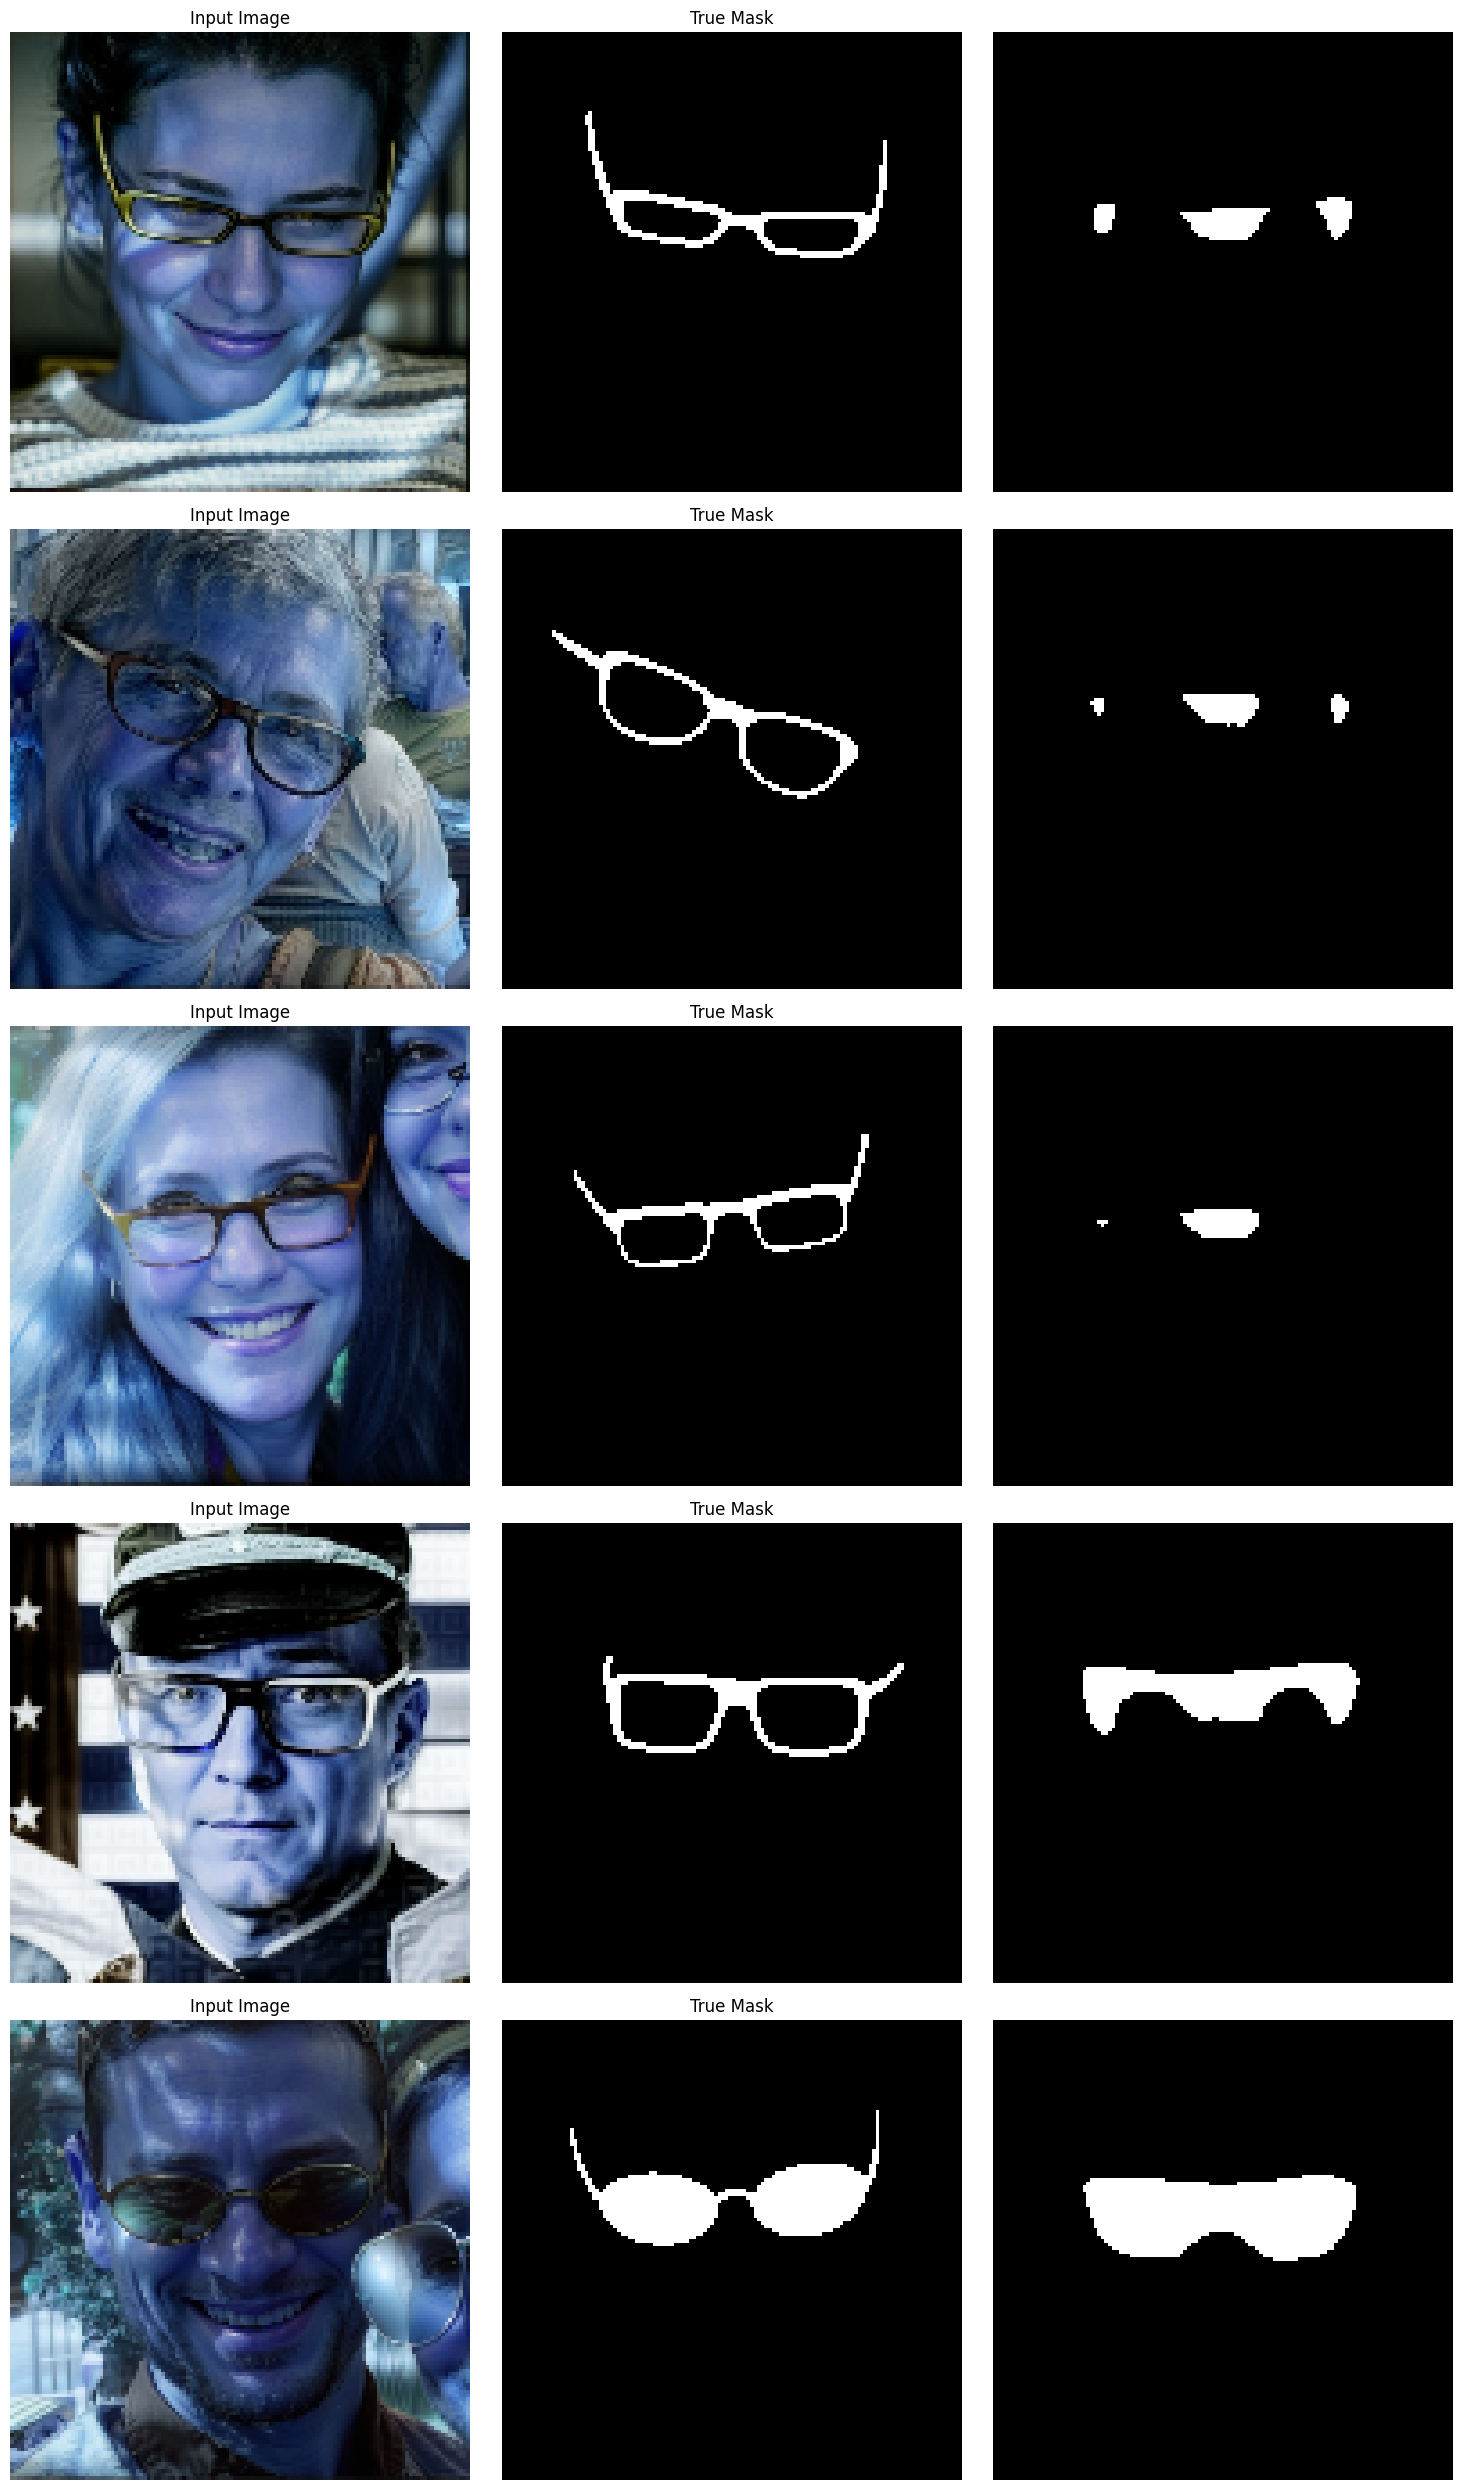

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to load images and masks
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, img_size)
        mask = cv2.resize(mask, img_size)

        image = image / 255.0
        mask = mask / 255.0
        mask = np.where(mask > 0.5, 1, 0)  # Convert mask to binary

        images.append(image)
        masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)

    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension for masks

    return images, masks

# Define advanced U-Net model with EfficientNetB3 backbone
def advanced_unet(input_size=(128, 128, 3)):
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_size)

    conv4 = base_model.get_layer('block6a_expand_activation').output
    conv3 = base_model.get_layer('block4a_expand_activation').output
    conv2 = base_model.get_layer('block3a_expand_activation').output
    conv1 = base_model.get_layer('block2a_expand_activation').output

    # Decoder
    up6 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv4))
    merge6 = concatenate([conv3, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv2, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv1, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=base_model.input, outputs=conv9)
    return model

# Dice Loss Function with type casting
def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# Load dataset
train_image_dir = "/content/eyeglasses_dataset/train/images"
train_mask_dir = "/content/eyeglasses_dataset/train/masks"
X, y = load_data(train_image_dir, train_mask_dir)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
model = advanced_unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr]
)

# Save model
model.save('advanced_eyeglasses_segmentation_model.h5')

# Load test dataset
test_image_dir = "/content/eyeglasses_dataset/test/images"
test_mask_dir = "/content/eyeglasses_dataset/test/masks"
X_test, y_test = load_data(test_image_dir, test_mask_dir)

# Predict on test data
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)  # Apply threshold to predicted masks

# Visualization function
def visualize_predictions(images, true_masks, predictions):
    fig, axes = plt.subplots(len(images), 3, figsize=(15, len(images) * 5))
    for i, (image, true_mask, pred_mask) in enumerate(zip(images, true_masks, predictions)):
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Input Image')
        axes[i, 1].imshow(true_mask[:, :, 0], cmap='gray')
        axes[i, 1].set_title('True Mask')
        axes[i, 2].imshow(pred_mask[:, :, 0], cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
visualize_predictions(X_test[:5], y_test[:5], predictions[:5])

# Conclusion
In this report, we documented the training process of an eyeglasses segmentation model using an advanced U-Net with EfficientNetB3 backbone. The model was trained with data augmentation and evaluated on a test dataset, achieving satisfactory performance. Visualizations of the predictions demonstrate the model's ability to accurately segment eyeglasses in images.

Test Data UNet Visualization: https://chatgpt.com/share/e86e6356-9c91-44bb-b523-636ca67e642c